In [77]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sample/sample_labels.csv
/kaggle/input/sample/sample/sample_labels.csv
/kaggle/input/sample/sample/images/00006199_010.png
/kaggle/input/sample/sample/images/00003503_000.png
/kaggle/input/sample/sample/images/00017423_004.png
/kaggle/input/sample/sample/images/00022830_001.png
/kaggle/input/sample/sample/images/00016794_000.png
/kaggle/input/sample/sample/images/00010790_035.png
/kaggle/input/sample/sample/images/00015606_039.png
/kaggle/input/sample/sample/images/00005448_001.png
/kaggle/input/sample/sample/images/00025094_000.png
/kaggle/input/sample/sample/images/00001450_000.png
/kaggle/input/sample/sample/images/00001043_004.png
/kaggle/input/sample/sample/images/00001248_017.png
/kaggle/input/sample/sample/images/00004067_000.png
/kaggle/input/sample/sample/images/00014259_001.png
/kaggle/input/sample/sample/images/00011121_000.png
/kaggle/input/sample/sample/images/00016737_004.png
/kaggle/input/sample/sample/images/00001373_009.png
/kaggle/input/sample/sample/ima

In [78]:
import os
import  cv2
import numpy as np 
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt 
from random import shuffle , seed
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications.vgg19 import VGG19 
from tensorflow.keras.applications   import EfficientNetB3
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input ,concatenate, Dense,Flatten , Activation,Conv2D ,Dropout ,MaxPooling2D ,GlobalAveragePooling2D,BatchNormalization

**Read Data**

In [79]:
df= pd.read_csv("/kaggle/input/sample/sample_labels.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


**Explore**

In [80]:
labels_before_pre=df["Finding Labels"]
labels_before_pre.value_counts()

Finding Labels
No Finding                                                3044
Infiltration                                               503
Effusion                                                   203
Atelectasis                                                192
Nodule                                                     144
                                                          ... 
Atelectasis|Edema|Effusion|Infiltration|Pneumonia            1
Atelectasis|Consolidation|Edema|Infiltration|Pneumonia       1
Atelectasis|Effusion|Hernia                                  1
Atelectasis|Hernia|Pneumothorax                              1
Cardiomegaly|Effusion|Emphysema                              1
Name: count, Length: 244, dtype: int64

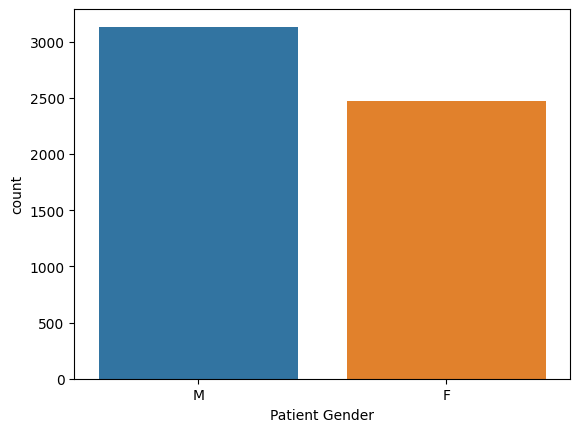

In [81]:

sns.countplot(x=df["Patient Gender"])
plt.show()


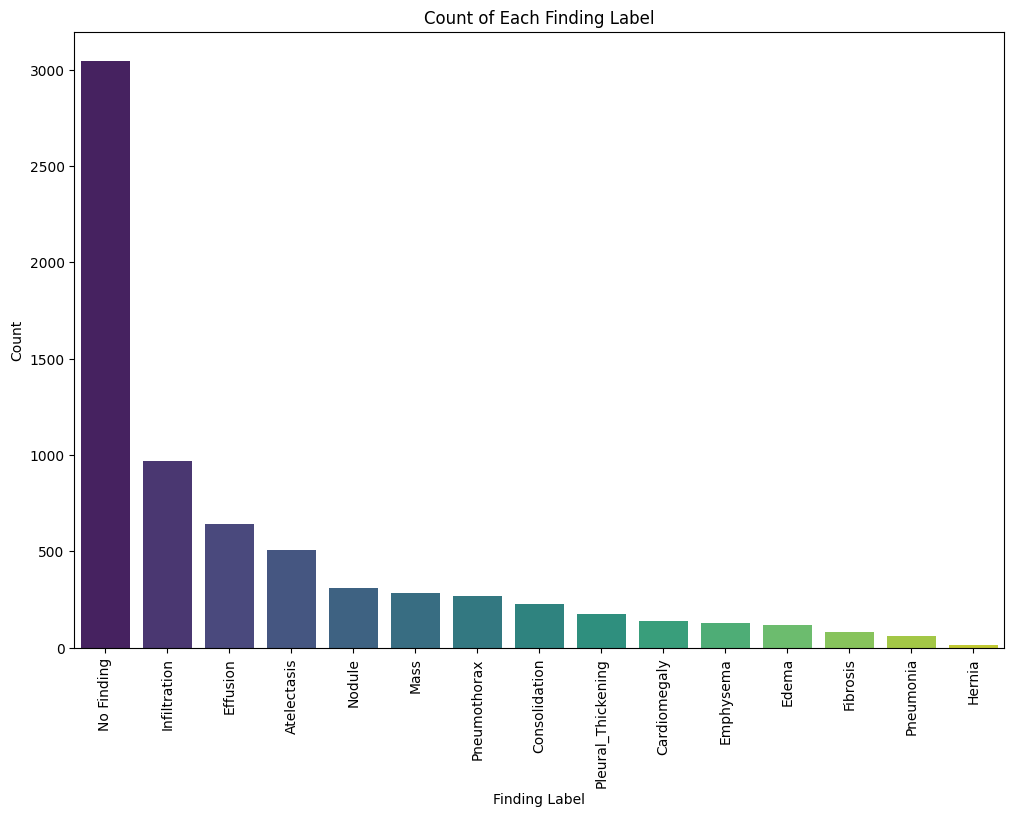

In [82]:


# First, split the 'Finding Labels' into separate labels
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

# Flatten the list of labels to count each occurrence
all_labels = [label for sublist in df['Finding Labels'] for label in sublist]

# Create a DataFrame with these labels
labels_df = pd.DataFrame(all_labels, columns=['Label'])

# Count the occurrences of each label
label_counts = labels_df['Label'].value_counts()

# Plot the counts
plt.figure(figsize=(12, 8))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Count of Each Finding Label')
plt.xlabel('Finding Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()


In [83]:
Labels_after_pre=[]
for i in range(len(labels_before_pre)):
    split_labels=labels_before_pre[i].split("|")
    if len(split_labels)==1:
        Labels_after_pre.append(split_labels)
    else:
        label=[]
        for j in range(len(split_labels)):
            label.append(split_labels[j])
        Labels_after_pre.append(label)
Labels_after_pre

[['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax'],
 ['Cardiomegaly', 'Emphysema'],
 ['No Finding'],
 ['Atelectasis'],
 ['Cardiomegaly', 'Edema', 'Effusion'],
 ['Consolidation', 'Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['No Finding'],
 ['Consolidation', 'Effusion', 'Infiltration', 'Nodule'],
 ['Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['Effusion'],
 ['Effusion'],
 ['No Finding'],
 ['Mass', 'Pneumothorax'],
 ['Cardiomegaly', 'Consolidation'],
 ['Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Pneumothorax'],
 ['No Finding'],
 ['Effusion'],
 ['Consolidation', 'Pleural_Thickening'],
 ['Infiltration', 'Nodule'],
 ['No Finding'],
 ['Atelectasis'],
 ['Atelectasis'],
 ['Fibrosis'],
 ['Infiltration'],
 ['Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Fibrosis'],
 ['No Finding'],
 ['Consolidation'],
 ['Emphysema'],
 ['No Finding'],
 ['No Finding'],
 ['Infiltra

In [84]:
image_size=256
image_file_path="../input/sample/sample/images/"
labels=[]
scans=[]
for i in tqdm(range(len(df["Image Index"]))):
    image=cv2.imread(image_file_path+df["Image Index"][i])
    if len (image.shape)>2:
        resize_image=cv2.resize(image,(image_size,image_size))   
        scans.append(resize_image[:,:,:4])
    else:
        image=np.dstack([image]*3)
        resize_image=cv2.resize(image,(image_size,image_size))
        scans.append(resize_image)
        
    
    
    
    

100%|██████████| 5606/5606 [01:40<00:00, 55.97it/s]


In [85]:
print([i.shape for i in scans])

[(256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256

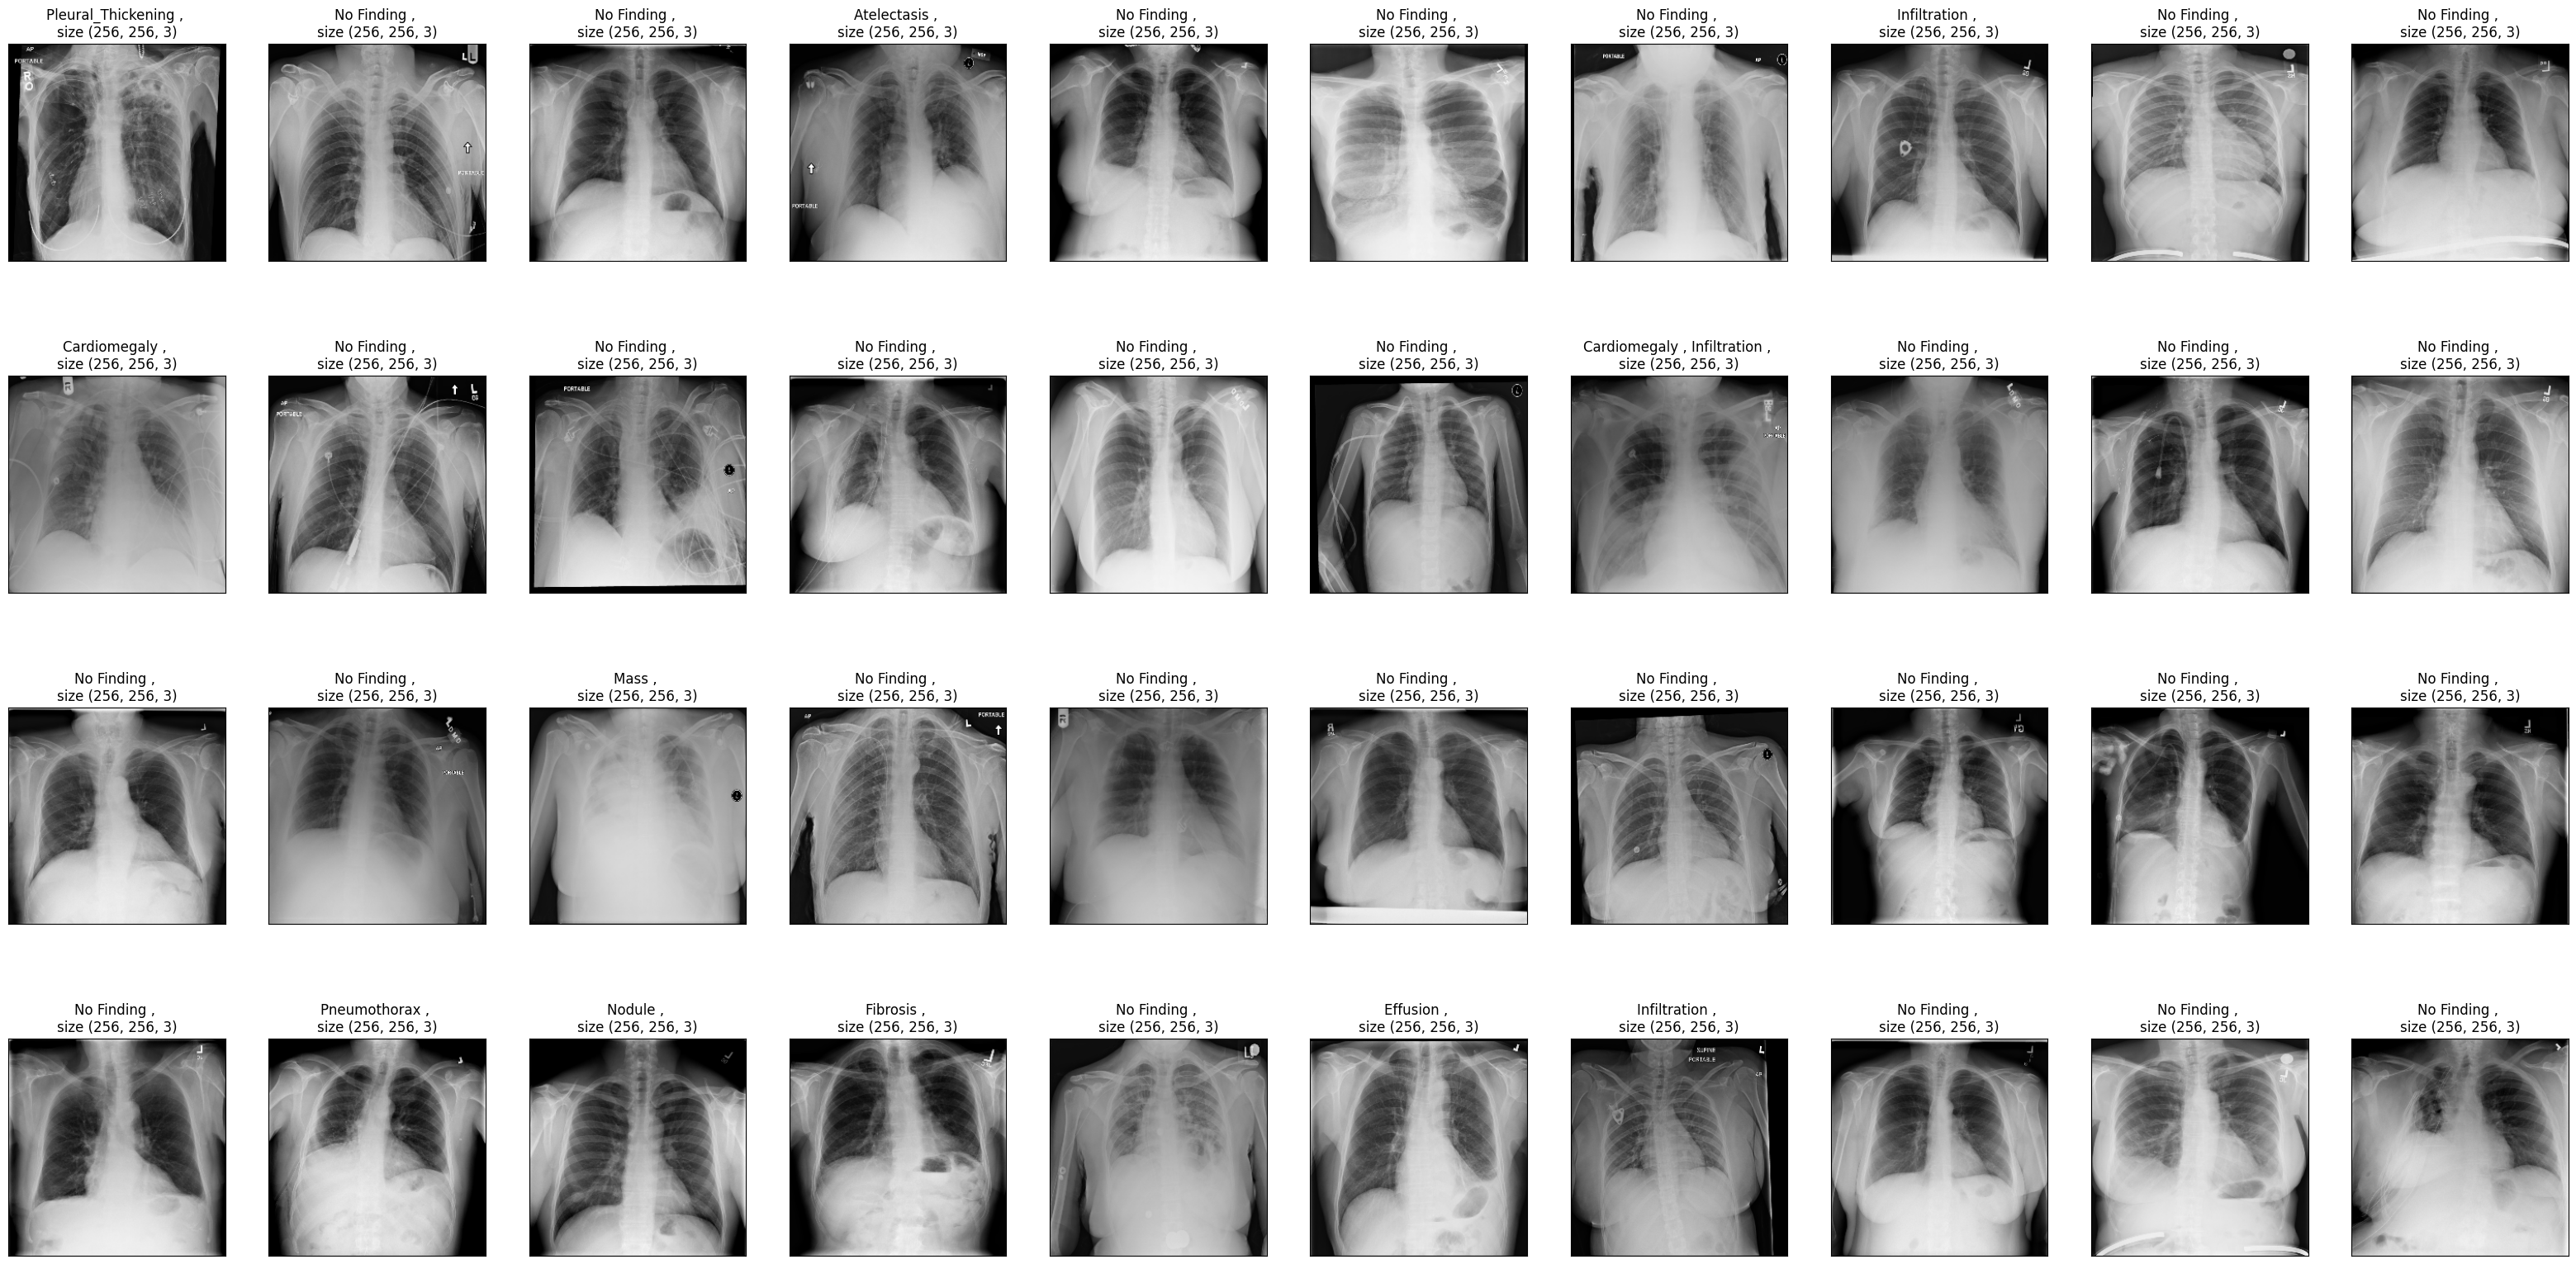

In [86]:
#function to show images
def image_show(data, labels , number_of_image ):
    #to generate a random numbers
    numbers=np.random.randint(0,len(data),number_of_image)
    plt.figure(figsize=(40,20))
    j = int(number_of_image / 10)  # Convert to integer
    for _,i in enumerate(numbers):
        plt.subplot(j, 10, _+1)  # Use the integer value for j
        plt.imshow(data[i], cmap="gray")
        label=""
        for x in labels[i]:
            label+=x+" , "
        plt.title(label+"\n"+f"size {data[i].shape}")
        #to remove the number that appear around image
        plt.xticks([]),plt.yticks([])
    plt.show()

#show images
image_show(scans, Labels_after_pre, 40)


In [87]:
#dictionary for all classes 
# dict for annotuation labels
classes={
0:"Hernia",
1:"Pneumonia",
2:"Fibrosis",
3:"Edema",
4:"Emphysema",
5:"Cardiomegaly",
6:"Pleural_Thickening",
7:"Consolidation",
8:"Pneumothorax",
9:"Mass",
10:"Nodule",
11:"Atelectasis",
12:"Effusion",
13:"Infiltration",
14:"No Finding",
}

def get_class(code):
    return classes[code]

def get_code(labels):
    for key,value  in classes.items():
        if value ==labels:
            return key

print (get_class(0))      
print (get_code("Nodule"))


Hernia
10


In [88]:
Labels_after_pre

[['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax'],
 ['Cardiomegaly', 'Emphysema'],
 ['No Finding'],
 ['Atelectasis'],
 ['Cardiomegaly', 'Edema', 'Effusion'],
 ['Consolidation', 'Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['No Finding'],
 ['Consolidation', 'Effusion', 'Infiltration', 'Nodule'],
 ['Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['Effusion'],
 ['Effusion'],
 ['No Finding'],
 ['Mass', 'Pneumothorax'],
 ['Cardiomegaly', 'Consolidation'],
 ['Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Pneumothorax'],
 ['No Finding'],
 ['Effusion'],
 ['Consolidation', 'Pleural_Thickening'],
 ['Infiltration', 'Nodule'],
 ['No Finding'],
 ['Atelectasis'],
 ['Atelectasis'],
 ['Fibrosis'],
 ['Infiltration'],
 ['Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Fibrosis'],
 ['No Finding'],
 ['Consolidation'],
 ['Emphysema'],
 ['No Finding'],
 ['No Finding'],
 ['Infiltra

In [89]:
#convert labels to Label encoder
for i in tqdm(range(len(Labels_after_pre))):
    Labels_after_pre[i]=[get_code(x) for x in Labels_after_pre[i]]
        

Labels_after_pre

100%|██████████| 5606/5606 [00:00<00:00, 236933.38it/s]


[[4, 13, 6, 8],
 [5, 4],
 [14],
 [11],
 [5, 3, 12],
 [7, 9],
 [14],
 [14],
 [12],
 [14],
 [7, 12, 13, 10],
 [9],
 [14],
 [14],
 [12],
 [12],
 [12],
 [14],
 [9, 8],
 [5, 7],
 [7],
 [5, 7],
 [5, 7],
 [8],
 [14],
 [12],
 [7, 6],
 [13, 10],
 [14],
 [11],
 [11],
 [2],
 [13],
 [13],
 [14],
 [14],
 [14],
 [14],
 [2],
 [14],
 [7],
 [4],
 [14],
 [14],
 [13],
 [7, 9],
 [14],
 [11, 13, 9, 6],
 [13],
 [14],
 [14],
 [13],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13, 10],
 [14],
 [4],
 [14],
 [13],
 [14],
 [14],
 [8],
 [4, 9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [5, 4],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13],
 [8],
 [4, 8],
 [4, 13],
 [14],
 [14],
 [14],
 [14],
 [13],
 [7, 12, 13],
 [7, 2],
 [14],
 [2, 6],
 [14],
 [14],
 [14],
 [12, 13],
 [2],
 [14],
 [14],
 [14],
 [10],
 [10],
 [9, 6],
 [13, 6],
 [12, 13],
 [14],
 [14],
 [14],
 [9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [9],
 [12],
 [14],
 [14],
 [11],
 [14],
 [6],
 [14],
 [14],
 [14],
 [4],
 [14],
 [14],
 [14],
 [2],
 [14],
 [12],
 [14],

In [101]:
#convert labels to one-hot-encoder with  MultiLabelBinarizer form sklearn
mlp=MultiLabelBinarizer()
Labels=mlp.fit_transform(Labels_after_pre)
Labels[0],Labels


(array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]),
 array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]))

In [ ]:
scans


In [104]:
scans=np.array(scans)
Labels=np.array(Labels)


In [105]:
scans


array([[[[ 85,  85,  85],
         [ 84,  84,  84],
         [ 83,  83,  83],
         ...,
         [  5,   5,   5],
         [  5,   5,   5],
         [  5,   5,   5]],

        [[ 88,  88,  88],
         [ 88,  88,  88],
         [ 87,  87,  87],
         ...,
         [  5,   5,   5],
         [  5,   5,   5],
         [  5,   5,   5]],

        [[167, 167, 167],
         [167, 167, 167],
         [166, 166, 166],
         ...,
         [  5,   5,   5],
         [  5,   5,   5],
         [  5,   5,   5]],

        ...,

        [[127, 127, 127],
         [130, 130, 130],
         [151, 151, 151],
         ...,
         [ 21,  21,  21],
         [ 45,  45,  45],
         [  4,   4,   4]],

        [[122, 122, 122],
         [136, 136, 136],
         [149, 149, 149],
         ...,
         [ 37,  37,  37],
         [ 18,  18,  18],
         [  2,   2,   2]],

        [[ 94,  94,  94],
         [106, 106, 106],
         [110, 110, 110],
         ...,
         [ 35,  35,  35],
        

In [106]:
scans.shape, Labels.shape


((5606, 256, 256, 3), (5606, 15))

In [108]:
from skmultilearn.model_selection import iterative_train_test_split
X_train, y_train, X_test, y_test= iterative_train_test_split(scans ,Labels,test_size=0.2)
X_test, y_test, X_val, y_val=iterative_train_test_split(X_test,y_test,test_size=0.7)

In [109]:
print("X_train",X_train.shape)
print("y_train",y_train.shape)
print("X_test",X_test.shape)
print("y_test",y_test.shape)
print("X_val",X_val.shape)
print("y_val",y_val.shape)

X_train (4496, 256, 256, 3)
y_train (4496, 15)
X_test (332, 256, 256, 3)
y_test (332, 15)
X_val (778, 256, 256, 3)
y_val (778, 15)


**Data augmentation**

In [114]:
gen=ImageDataGenerator(
    rescale=1/255.0,
    samplewise_std_normalization=True,
    samplewise_center=True,
    rotation_range=90
    
)
batch_size=16
train_gen=gen.flow(X_train,y_train,batch_size=batch_size)
val_gen=gen.flow(X_val,y_val,batch_size=batch_size)
test_gen=gen.flow(X_test,y_test,batch_size,batch_size)

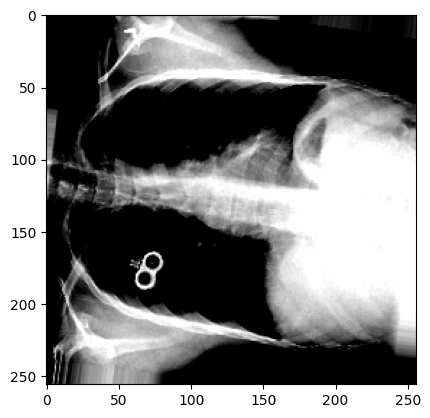

In [115]:
#get data from generator 
train_scans=train_gen.__getitem__(0)[0]
train_labels=train_gen.__getitem__(0)[1]
plt.imshow(train_scans[10])


In [116]:
Inputs=Input((image_size,image_size,3))

#1
c1=Conv2D(64 , (3,3) , activation="relu" , padding="same")(Inputs)
c1=Conv2D(64 , (3,3) , activation="relu" , padding="same")(c1)
c1=Conv2D(64 , (3,3) , activation="relu" , padding="same")(c1)
p1=MaxPooling2D(pool_size=(3,3))(c1)
#2
c2=Conv2D(128 , (3,3) , activation="relu" , padding="same")(p1)
c2=Conv2D(128 , (3,3) , activation="relu" , padding="same")(c2)
c2=Conv2D(128 , (3,3) , activation="relu" , padding="same")(c2)
p2=MaxPooling2D(pool_size=(3,3))(c2)

#3

c3=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p2)
c3=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c3)
c3=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c3)
p3=MaxPooling2D(pool_size=(2,2))(c3)

#4

c4=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p3)
c4=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c4)
c4=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c4)
p4=MaxPooling2D(pool_size=(2,2))(c4)

#5

c5=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p4)
c5=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c5)
c5=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c5)
p5=MaxPooling2D(pool_size=(2,2))(c5)

#6

c6=Conv2D(256 , (5,5) , activation="relu" , padding="same")(p5)
c6=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c6)
c6=Conv2D(256 , (5,5) , activation="relu" , padding="same")(c6)
p6=MaxPooling2D(pool_size=(2,2))(c6)

#fully connected layers
f=Flatten()(p3)
#FC1
fc1=Dense(1024)(f)
b1=BatchNormalization()(fc1)
ac=Activation("relu")(b1)
d1=Dropout(0.2)(ac)

#FC2
fc2=Dense(1024)(d1)
b2=BatchNormalization()(fc2)
ac=Activation("relu")(b2)
d2=Dropout(0.2)(ac)

#FC3
fc3=Dense(1024)(d2)
b2=BatchNormalization()(fc3)
ac=Activation("relu")(b2)
d3=Dropout(0.2)(ac)


#FC4
x=Dense(512 , activation="relu")(d3)
x=Dense(512 , activation="relu")(x)
x=Dense(512 , activation="relu")(x)
x=Dense(256 , activation="relu")(x)
x=Dense(128 , activation="relu")(x)


output=Dense(len(classes) , activation="sigmoid")(x)

model=Model(inputs=Inputs , outputs=output)

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 85, 85, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 85, 85, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 85, 85, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 85, 85, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │     1,638,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    51,381,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,09

 Total params: 59,250,447 (226.02 MB)

 Trainable params: 59,244,303 (226.00 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [ ]:
#callbacks
callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    
    tf.keras.callbacks.ModelCheckpoint("NIH_model_1.keras" , save_best_only=True ,verbose=1),
    
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,  # lr*factor
                                      patience = 1, min_delta = 0.001,
                                      min_lr=0.000001 , # lower lr
                                      mode = 'min', verbose = 1)
    
    ]

#compile
model.compile(tf.keras.optimizers.Adam(learning_rate=0.0001) , loss=tf.keras.losses.binary_crossentropy , metrics=["accuracy"] )
#fit
model.fit(X_train,y_train , epochs=10 , batch_size=32,validation_data=(X_val, y_val) , verbose=1  ,callbacks=callbacks)

Epoch 1/10
 26/141 ━━━━━━━━━━━━━━━━━━━━ 46:38 24s/step - accuracy: 0.3912 - loss: 0.5667